In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import shap
import math

In [2]:
def clean_dataset(path_to_csv):
    """
    Cleans the dataset and drops duplicates
    """
    df=pd.read_csv(path_to_csv)
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df=df.dropna()
    df=df.drop_duplicates()
    return df


def get_peirels_nabarro_stress(r,G):
    
    """
    Returns the peirels nabarro stress in Mpa with given radius in angstorm and shear modulus in Gpa
    Formula used: Tp(Pierels Nabarro Stress)= (G/(1-poissons))*exp(-4*pi*chai/b)
    d=avg interplanar spacing {110},{112}
    d=(a/root(2) + a/root(6))/2
    b=0.866a = a/2<hkl> =a/2<111> slip direction
    a=4*r_avg/root(3) for BCC structure
    """
    a=4*r/(math.sqrt(3))
    d=(a/math.sqrt(2))
    d+=(a/math.sqrt(6))
    d=d/2  
    chai=(d/(2*(1-0.33)))
    b=0.866*a
    intra_exp=(-1*4*math.pi*chai)/b
    pre_exp=G/(1-0.33)
    p_n_s=pre_exp*math.exp(intra_exp)*1000 #for making into mega pascal
    return p_n_s


def random_forest_model(df,featuresTaken,predict_on):
    
    """
    Creates a random forest model and returns meanwhile printing errors etc on the model
    
    Input: dataset, features to take for training, feature to predict
    
    """
    X=df[featuresTaken]
    y=df[predict_on]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    RF=RandomForestRegressor(n_estimators=1000)

    RF.fit(X_train,y_train)

    predict=RF.predict(X_test)

    rms=np.sqrt(metrics.mean_squared_error(predict,y_test))
    abserr=metrics.mean_absolute_error(predict,y_test)
    percentage_error=np.mean(np.abs((y_test - predict) / y_test)) * 100
    print(f'RMS error= {rms}\nAbsolute Error= {abserr}\nPercentage Error={percentage_error}')
    perror=(predict-y_test)*100/y_test #percentage Error
    aerror=(predict-y_test); #absolute error
    
    return RF



def plot_graph(predict,y_test,predict_on):
    
    n=y_test.shape[0]

    plt.figure(figsize=(20,10))
    plt.plot(range(0,n),predict,label='predicted Value',marker='^',lw=2)
    plt.plot(range(0,n),y_test,label='True Value',marker='^',lw=2)
    perror=(predict-y_test)*100/y_test
    plt.plot(range(0,n),perror,marker='^',color='red',label='percentage error',lw=2)
    
    for i in range(0,n):
        plt.annotate(df[df[predict_on]==y_test.tolist()[i]]['alloy_name'].values[0],(i,y_test.tolist()[i]),rotation=90)
        
    for i in range(0,n):
        plt.annotate(round(perror.tolist()[i]),(i,perror.tolist()[i]),fontsize=10)
        
    plt.xlabel('Index',fontsize=15)
    plt.ylabel(predict_on,fontsize=15)
    plt.legend()

def filter_to_default(df,main_dataset):
    """
    Filter to base alloys
    """
    return df[df['alloy_name'].apply(lambda x: x in main_dataset['alloy_name'].to_list())]

def cross_validation_m(df,featuresTaken,predict_on,RF):
    """
    Takes input of database and features to take as well as the model on which 5 fold cros validation to apply
    returns rms_array, abs_error array and percentage error array
    """
    X=df[featuresTaken]
    y=df[predict_on]
    data=dict()
    rms_l=[]
    abs_l=[]
    p_l=[]
    kfold=KFold(5)
    i=0
    for train_idx, test_idx in kfold.split(X):
        i+=1
        X1_train,X1_test=X.iloc[train_idx],X.iloc[test_idx]
        y1_train,y1_test=y.iloc[train_idx],y.iloc[test_idx]
        RF.fit(X1_train,y1_train)
        predict=RF.predict(X1_test)
        rms=np.sqrt(metrics.mean_squared_error(predict,y1_test))
        abserr=metrics.mean_absolute_error(predict,y1_test)
        percentage_error=np.mean(np.abs((y1_test - predict) / y1_test)) * 100
        data[i]=dict()
        data[i]['predict']=predict
        data[i]['y1_test']=y1_test
        rms_l.append(rms)
        abs_l.append(abserr)
        p_l.append(percentage_error)
    data['rms_l']=rms_l
    data['abs_l']=abs_l
    data['p_l']=p_l
    return data

In [3]:
r_avg_df=clean_dataset('Extracting_R_avg/r_avg.csv')

In [4]:
main_dataset=clean_dataset('myInput/reduced_phases.csv') 

In [5]:
shear_modulus_dataset_MPEA=clean_dataset('ShearModulus_using_youngsMod/test.csv')
shear_modulus_original=clean_dataset('ShearModulus_using_youngsMod/youngs_to_shear_original.csv')
#Already added shear modulus in excel also contains the youngs modulus data

In [6]:
r_avg_filtered_df=filter_to_default(r_avg_df,main_dataset)

In [7]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
predict_on='YS_Mpa'
random_forest_model(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'],featuresTaken,predict_on)

RMS error= 296.28764156841834
Absolute Error= 166.77900297619044
Percentage Error=10.38247450943655


RandomForestRegressor(n_estimators=1000)

In [8]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
predict_on='s_mod_GPa'
random_forest_shear_modulus_mpea_model=random_forest_model(shear_modulus_dataset_MPEA[shear_modulus_dataset_MPEA['phases']=='BCC'],featuresTaken,predict_on)

RMS error= 36.23256803739009
Absolute Error= 23.730676563217568
Percentage Error=5.705276181256575


In [9]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
predict_on='s_mod_GPa'
random_forest_shear_modulus_original_model=random_forest_model(shear_modulus_original[shear_modulus_original['phases']=='BCC'],featuresTaken,predict_on)

RMS error= 59.42838135349917
Absolute Error= 38.75304346666641
Percentage Error=14.41478607030178


In [10]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
r_avg_filtered_df['S_mod_GPa']=random_forest_shear_modulus_mpea_model.predict(r_avg_filtered_df[featuresTaken])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
pierels_nabarro_stress=[get_peirels_nabarro_stress(r_avg_filtered_df['R_avg'].to_list()[i],r_avg_filtered_df['S_mod_GPa'].to_list()[i]) for i in range(0,r_avg_filtered_df.shape[0])]

In [12]:
r_avg_filtered_df['p_n_stress']=np.array(pierels_nabarro_stress)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R','p_n_stress']
predict_on='YS_Mpa'
random_forest_model(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'],featuresTaken,predict_on)

RMS error= 296.22604510110915
Absolute Error= 168.63066152210882
Percentage Error=10.520449187834325


RandomForestRegressor(n_estimators=1000)

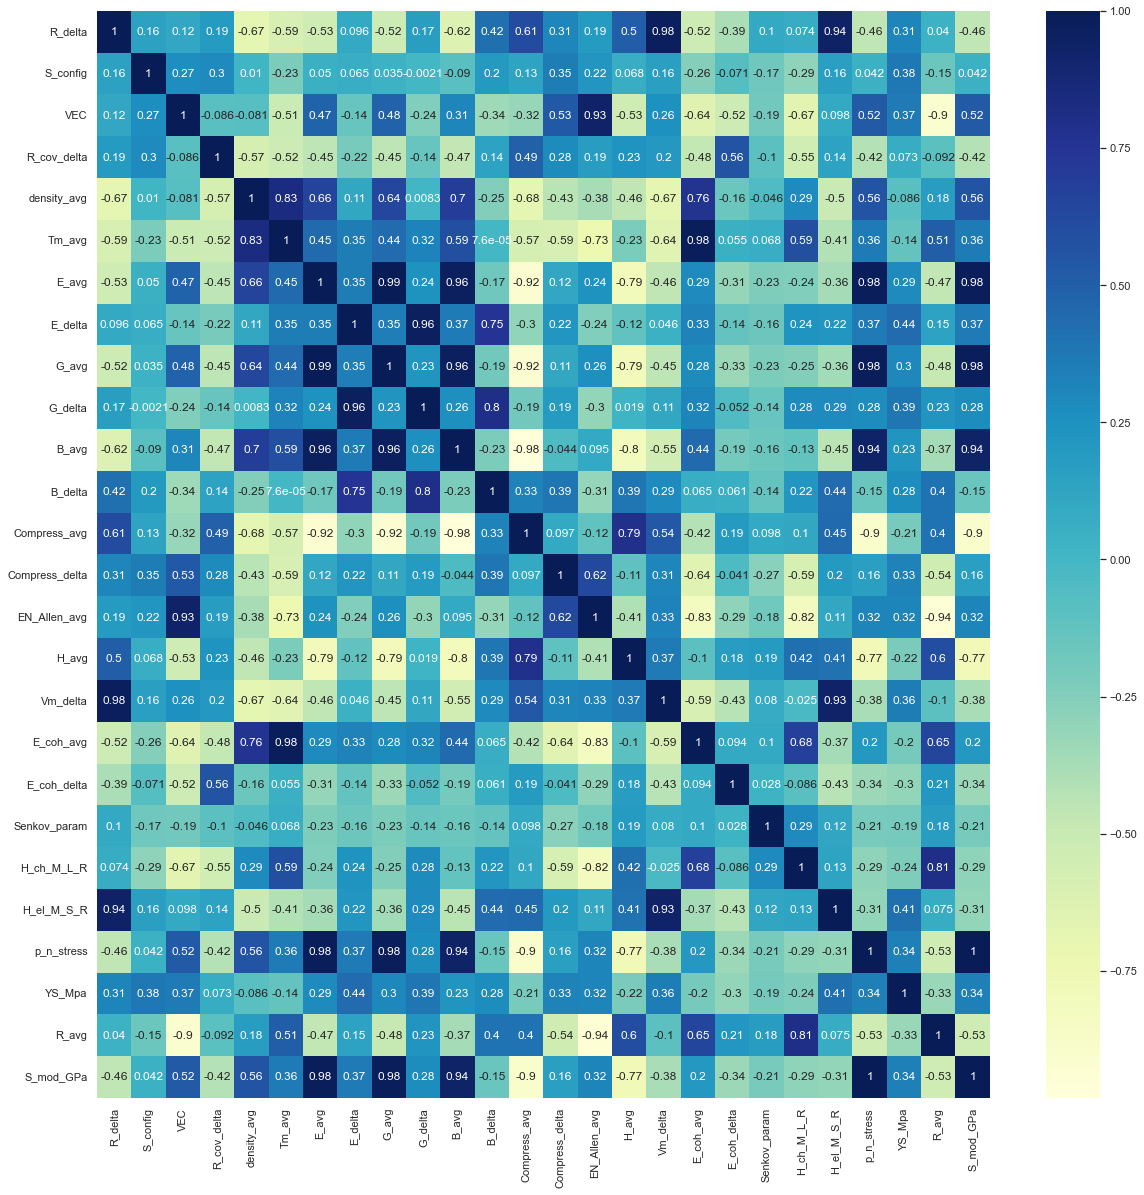

In [14]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R','p_n_stress','YS_Mpa','R_avg','S_mod_GPa']
sns.set(rc={'figure.figsize':(20,20)})

fig=sns.heatmap(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'][featuresTaken].corr(),cmap="YlGnBu", annot=True)

fig.figure.savefig('using_mpea_youngs_mod_dataset.png',dpi=200) 

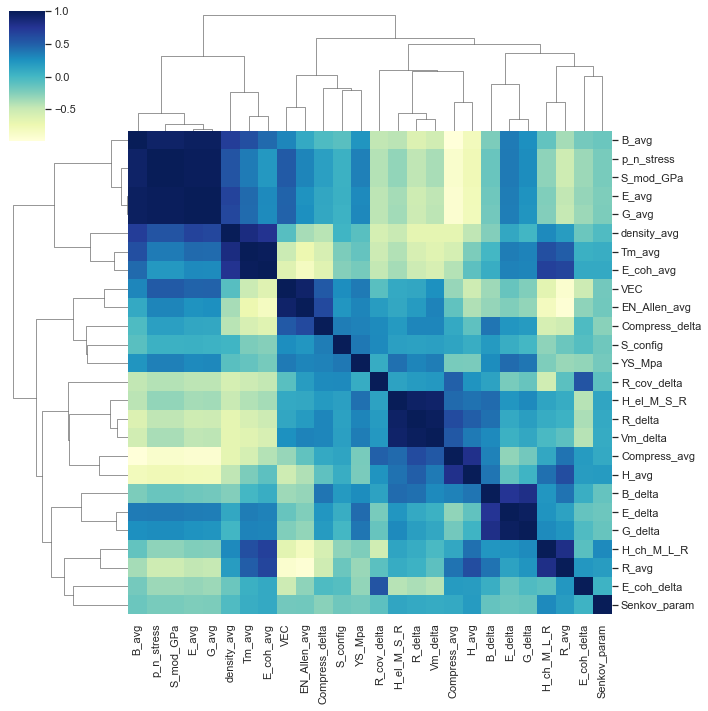

In [15]:
sns.set(rc={'figure.figsize':(30,30)})

sns.clustermap(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'][featuresTaken].corr(),cmap="YlGnBu")

In [16]:
r_avg_filtered_df=filter_to_default(r_avg_df,main_dataset)

In [17]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
r_avg_filtered_df['S_mod_GPa']=random_forest_shear_modulus_original_model.predict(r_avg_filtered_df[featuresTaken])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
pierels_nabarro_stress=[get_peirels_nabarro_stress(r_avg_filtered_df['R_avg'].to_list()[i],r_avg_filtered_df['S_mod_GPa'].to_list()[i]) for i in range(0,r_avg_filtered_df.shape[0])]

In [157]:
pierels_nabarro_stress
r_avg_filtered_df['p_n_stress']=np.array(pierels_nabarro_stress)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R','p_n_stress']
predict_on='YS_Mpa'
random_forest_model(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'],featuresTaken,predict_on)

RMS error= 295.7681502335926
Absolute Error= 164.4841152210885
Percentage Error=10.157680490814295


RandomForestRegressor(n_estimators=1000)

In [21]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R','p_n_stress','YS_Mpa','R_avg','S_mod_GPa']
sns.set(rc={'figure.figsize':(20,20)})

# fig=sns.heatmap(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'][featuresTaken].corr(),cmap="YlGnBu", annot=True)
# fig.figure.savefig('using_original_shear_mod_dataset.png',dpi=200) 

In [22]:
model_pierels_nabarro=random_forest_model(r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC'],featuresTaken,predict_on)

RMS error= 164.56633614637855
Absolute Error= 44.0787142857143
Percentage Error=2.1632622597776114


In [158]:
r_avg_filtered_df_BCC=r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC']

In [24]:
kfold=KFold(5,False)

Pass shuffle=False as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error


In [25]:
def cross_validation_m(df,featuresTaken,predict_on):
    X=df[featuresTaken]
    y=df[predict_on]
    rms_l=[]
    abs_l=[]
    p_l=[]
    RF=RandomForestRegressor(n_estimators=1000)
    for train_idx, test_idx in kfold.split(X):
        X1_train,X1_test=X.iloc[train_idx],X.iloc[test_idx]
        y1_train,y1_test=y.iloc[train_idx],y.iloc[test_idx]
        RF.fit(X1_train,y1_train)
        predict=RF.predict(X1_test)
        rms=np.sqrt(metrics.mean_squared_error(predict,y1_test))
        abserr=metrics.mean_absolute_error(predict,y1_test)
        percentage_error=np.mean(np.abs((y1_test - predict) / y1_test)) * 100
        rms_l.append(rms)
        abs_l.append(abserr)
        p_l.append(percentage_error)
    return rms_l,abs_l,p_l


In [26]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
predict_on='YS_Mpa'
rms_l,abs_l,p_l=cross_validation_m(r_avg_df[r_avg_df['phases']=='BCC'],featuresTaken,predict_on)

In [159]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R','p_n_stress']
predict_on='YS_Mpa'
df=r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC']
X=df[featuresTaken]
y=df[predict_on]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [160]:
RF=RandomForestRegressor(n_estimators=1000)
RF.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000)

In [161]:
y_predict=RF.predict(X_test)

In [162]:
np.mean(np.abs((y_predict-y_test)/y_test)*100)

10.221455955359994

In [124]:
n_estimators=[int(x) for x in np.linspace(start=10,stop=1000,num=10)]
max_features=['auto','sqrt']
max_depth=[2,4]
min_samples_split=[2,5]
min_samples_leaf=[1,2]
bootstrap=[True,False]

param_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap': [True,False]
}
print(param_grid)

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [125]:
"""
      n_estimators=100,
    *,
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
"""

"\n      n_estimators=100,\n    *,\n    criterion='mse',\n    max_depth=None,\n    min_samples_split=2,\n    min_samples_leaf=1,\n    min_weight_fraction_leaf=0.0,\n    max_features='auto',\n    max_leaf_nodes=None,\n    min_impurity_decrease=0.0,\n    min_impurity_split=None,\n    bootstrap=True,\n    oob_score=False,\n    n_jobs=None,\n    random_state=None,\n    verbose=0,\n    warm_start=False,\n    ccp_alpha=0.0,\n    max_samples=None,\n"

In [126]:
rf_Grid=GridSearchCV(estimator=RF,param_grid=param_grid,cv=5,verbose=2,n_jobs=4)

In [127]:
rf_Grid.fit(X_train,y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


KeyboardInterrupt: 

In [128]:
rf_Grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [129]:
rf_Grid.score(X_train,y_train)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [149]:
RF=RandomForestRegressor(bootstrap=True,max_depth=4,max_features='sqrt',min_samples_leaf=2,min_samples_split=5,n_estimators=50)

In [150]:
RF.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50)

In [151]:
y_predict=RF.predict(X_test)

In [152]:
np.mean(np.abs((y_predict-y_test)/y_test)*100)

13.027989984770429

In [14]:
featuresTaken=['R_delta', 'S_config', 'VEC',
       'R_cov_delta', 'density_avg', 'Tm_avg', 'E_avg', 'E_delta', 'G_avg',
       'G_delta', 'B_avg', 'B_delta', 'Compress_avg', 'Compress_delta',
       'EN_Allen_avg', 'H_avg', 'Vm_delta', 'E_coh_avg', 'E_coh_delta',
       'Senkov_param', 'H_ch_M_L_R', 'H_el_M_S_R']
predict_on='YS_Mpa'
df=r_avg_filtered_df[r_avg_filtered_df['phases']=='BCC']
X=df[featuresTaken]
y=df[predict_on]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sc= StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
RF=RandomForestRegressor(n_estimators=1000)
RF.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000)

In [15]:
y_predict=RF.predict(X_test)

In [16]:
np.mean(np.abs((y_predict-y_test)/y_test)*100)

10.46431195681169

In [17]:
data=cross_validation_m(df,featuresTaken,predict_on,RF)

In [18]:
data[1]['y1_test'].shape

(17,)

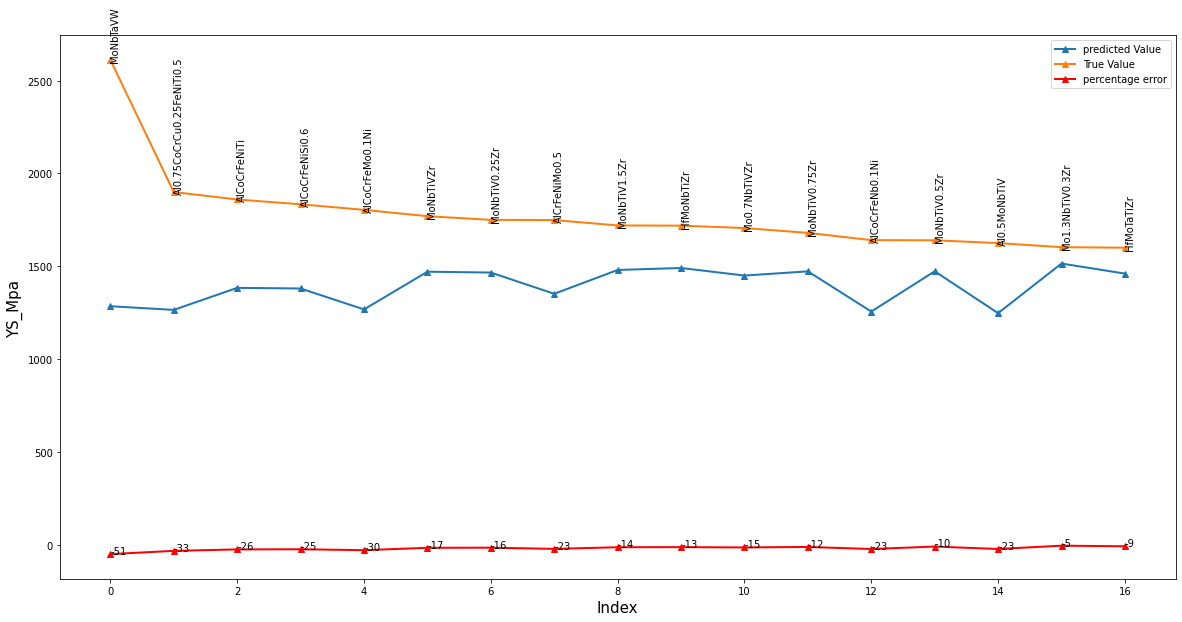

In [29]:
plot_graph(data[1]['predict'],data[1]['y1_test'],predict_on)

In [30]:
data['p_l']

[20.342101969488642,
 6.984873146032745,
 9.772578798181971,
 16.50794733594778,
 37.421249396179626]

In [55]:
val

{0: 1}